Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL01 Principal Component Analysis (PCA)

### Lab Description

This laboratory exercise introduces Principal Component Analysis (PCA), a fundamental dimensionality reduction technique widely used in machine learning and data analysis. PCA transforms high-dimensional data into a lower-dimensional representation while preserving the most important information (variance) in the dataset.

In this hands-on lab, you will preprocess the `Wine` dataset, perform PCA to analyze its structure, and visualize the results to gain deeper insights into the data.

### What you can expect to learn

- Theoretical Understanding: Grasp the mathematical foundations of PCA and its role in dimensionality reduction.
- Data Preprocessing: Master standardization techniques essential for PCA.
- Implementation PCA: Learn to implement PCA from scratch using eigendecomposition techniques.

### Import necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### Required Dataset
We use `Wine` Dataset for this lab.
More information can be found on its official website: https://archive.ics.uci.edu/dataset/109/wine

In [2]:
# Wine dataset
url = "https://raw.githubusercontent.com/SDeepDreamS/Remote-Lab-Datasets/refs/heads/main/wine.csv"
df_wine = pd.read_csv(url, header=1)

df_wine.columns = [
    "Class label",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]

x_wine = df_wine.drop("Class label", axis=1)  # remove class label 1
y_wine = df_wine["Class label"]

df_wine.head()

Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    13.20        1.78  2.14               11.2        100   
1            1    13.16        2.36  2.67               18.6        101   
2            1    14.37        1.95  2.50               16.8        113   
3            1    13.24        2.59  2.87               21.0        118   
4            1    14.20        1.76  2.45               15.2        112   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.65        2.76                  0.26             1.28   
1           2.80        3.24                  0.30             2.81   
2           3.85        3.49                  0.24             2.18   
3           2.80        2.69                  0.39             1.82   
4           3.27        3.39                  0.34             1.97   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             4.38  1.05                          3.40     1050  
1             5.68  1.03                          3.17     1185  
2             7.80  0.86                          3.45     1480  
3             4.32  1.04                          2.93      735  
4             6.75  1.05                          2.85     1450

### Seaborn Visualization and Pairwise Plotting
* `sns.set(...)` sets the plot style and scale for better readability in notebooks.
* `sns.pairplot(...)` creates scatter plots of all feature pairs, colored by wine class.
This helps us visualize relationships between features and see how well the classes are separated.

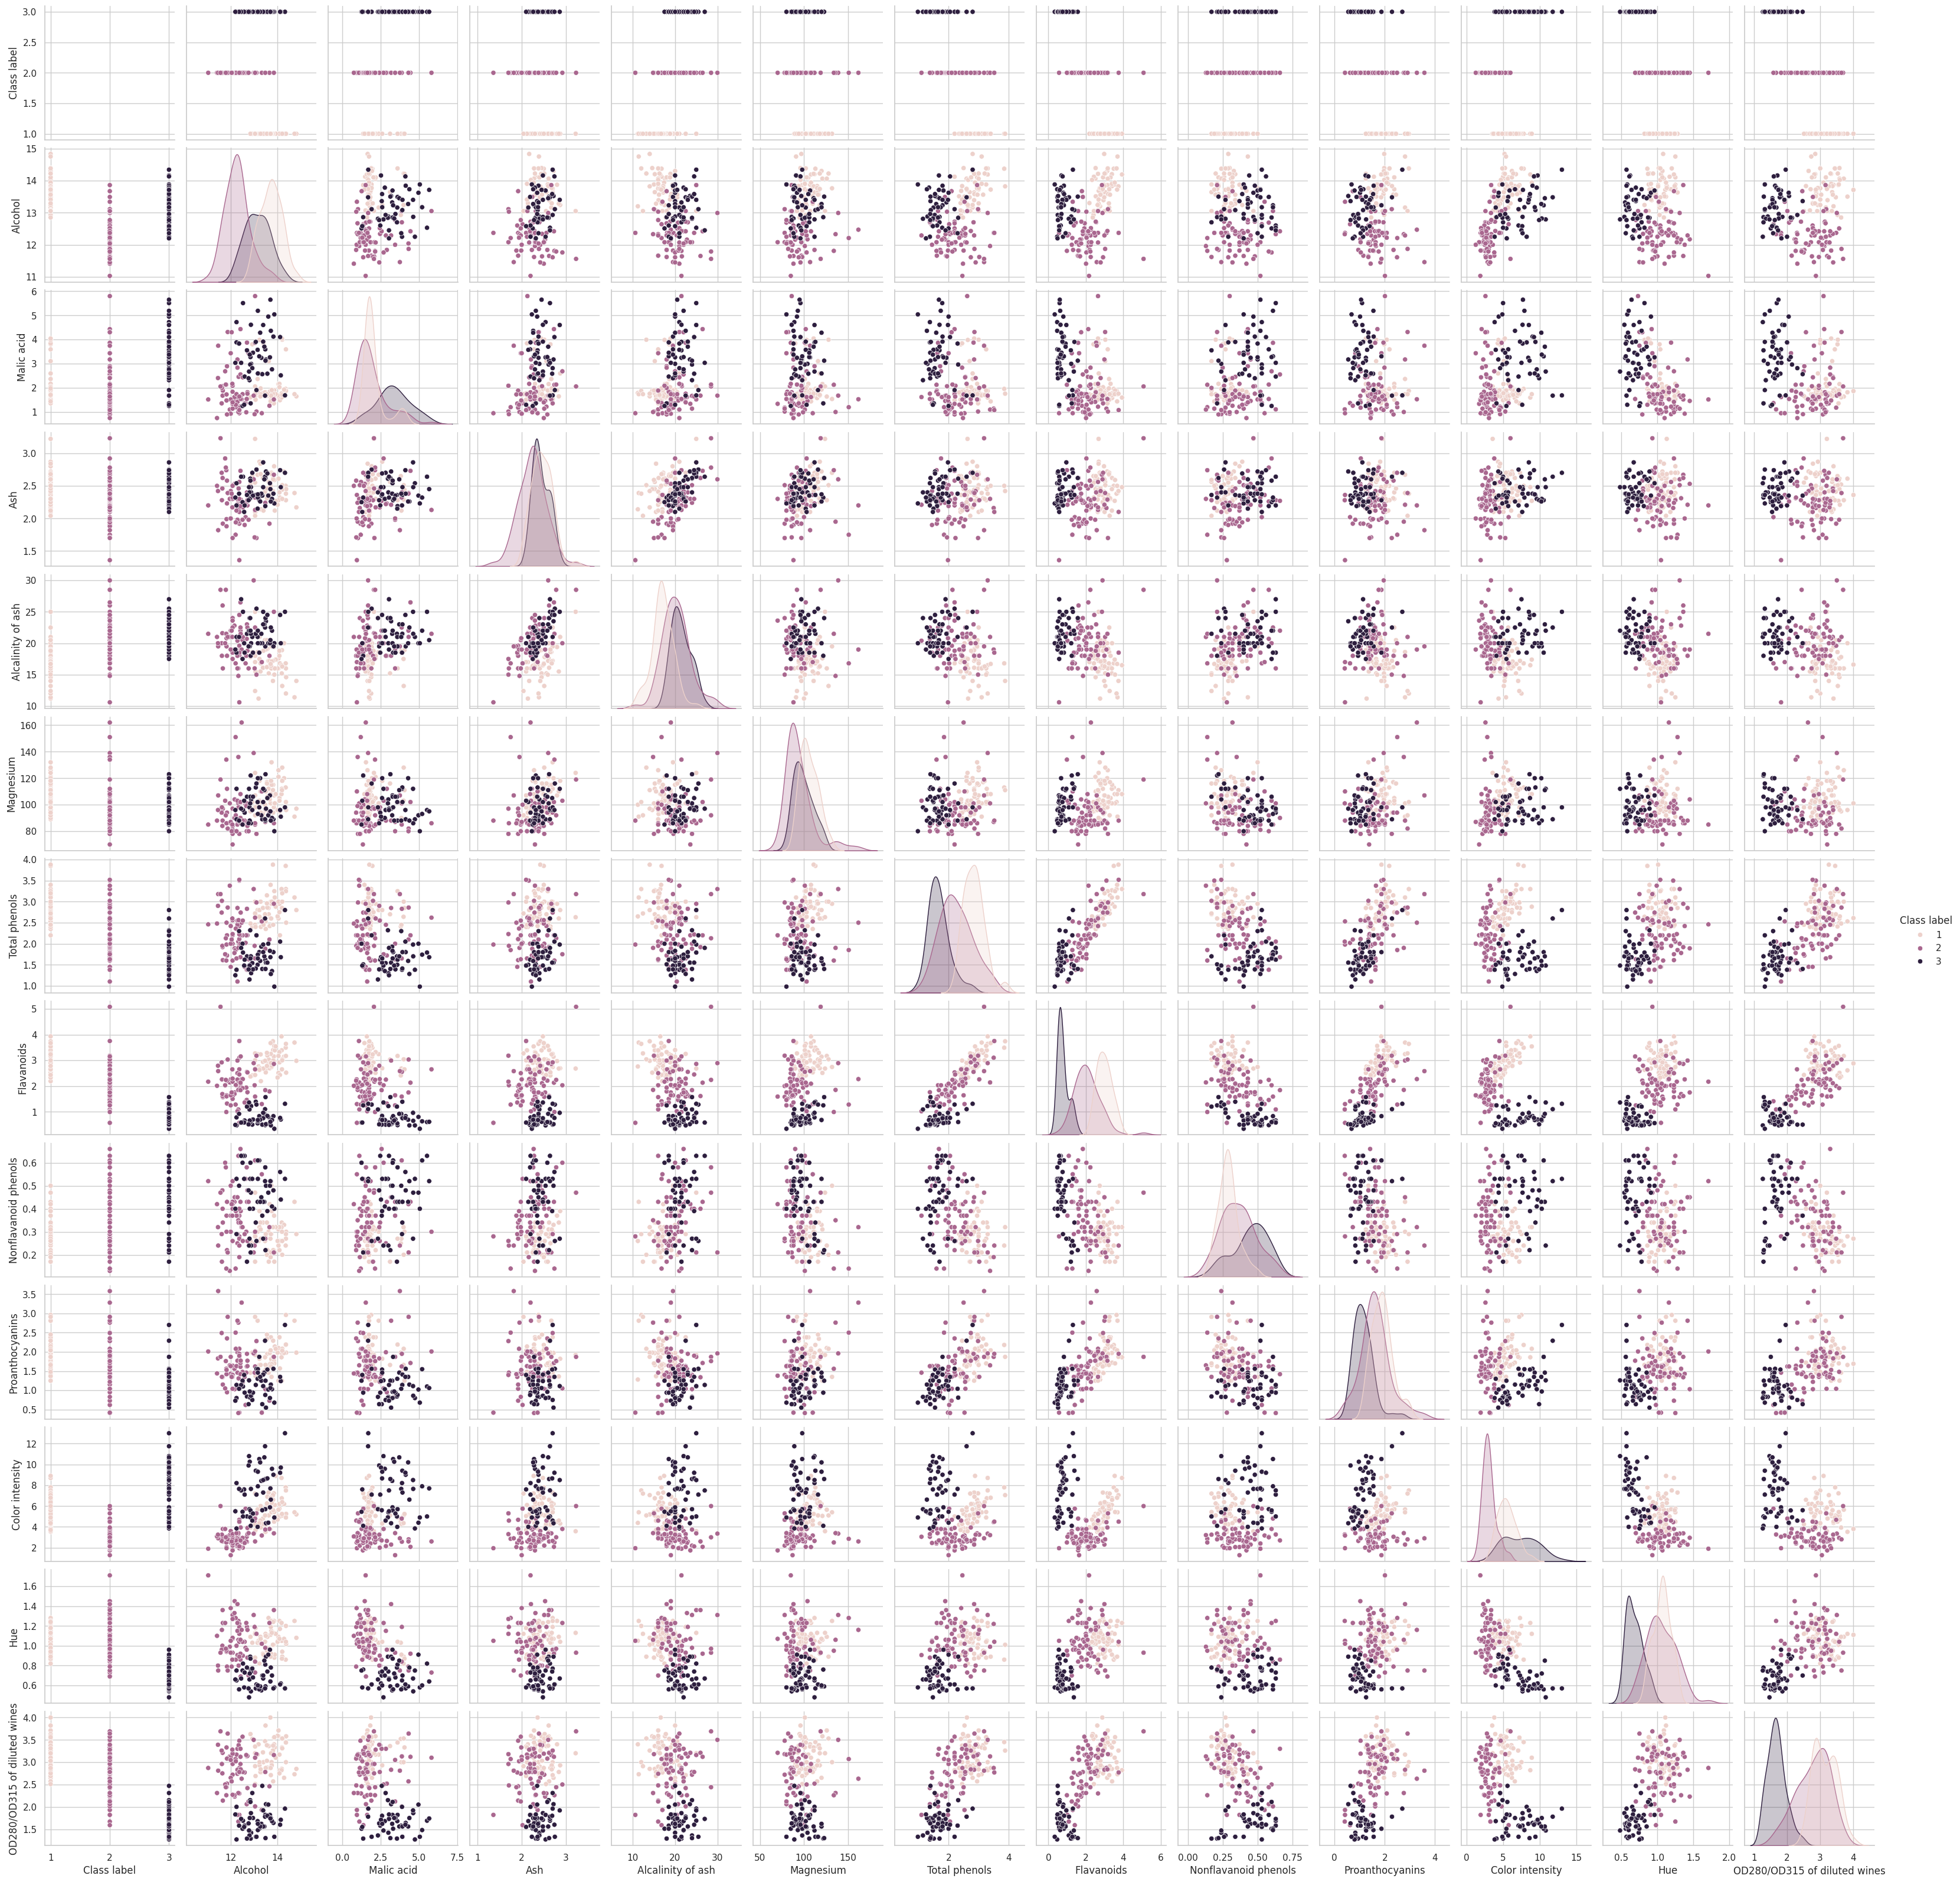

In [3]:
sns.set(style="whitegrid", context="notebook")
sns.pairplot(df_wine, vars=df_wine.columns[:-1], hue="Class label")

plt.show()

### Z-Normalization and Correlation Heatmap

We first apply **z-normalization** to standardize all features in `x_wine`, ensuring they have zero mean and unit variance.  
This is important to make features comparable and suitable for correlation analysis.

Next, we compute the **correlation matrix** of the standardized data to measure the linear relationships between features.  
Finally, we visualize this matrix using a **Seaborn heatmap** to easily identify which features are positively or negatively correlated.


In [4]:
# z-normalization
sc = StandardScaler()
z = sc.fit_transform(x_wine)

In [5]:
# correlation matrix
corr = np.dot(z.T, z) / x_wine.shape[0]

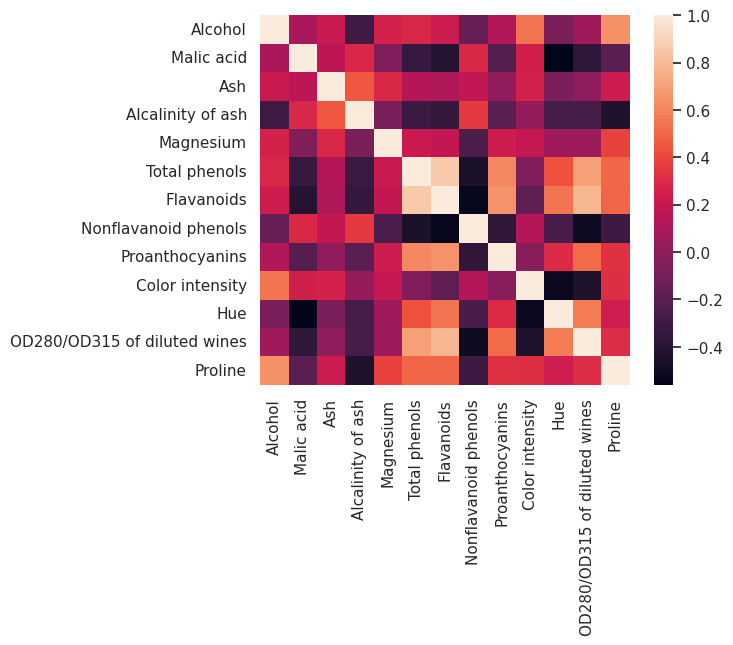

In [6]:
labels = list(x_wine.columns)
heatmap = sns.heatmap(corr, cbar=True, square=True, yticklabels=labels, xticklabels=labels)

plt.show()

### Analyze Data

We perform eigendecomposition on the correlation matrix to extract eigenvalues and eigenvectors, which represent the directions and magnitude of variance in the data. Then we compute the explained variance ratio for each principal component, indicating how much information (variance) each component retains.

This helps us decide how many principal components are needed to retain most of the data's variance.


In [7]:
# eigen values and eigen vectors
eigen_vals, eigen_vecs = np.linalg.eigh(corr)
print(f"Eigen values:\n{eigen_vals}")

Eigen values:
[0.10394972 0.16837682 0.22544019 0.24680867 0.28918002 0.35073883
 0.55198181 0.64484771 0.86173674 0.92444413 1.45332981 2.50136634
 4.6777992 ]


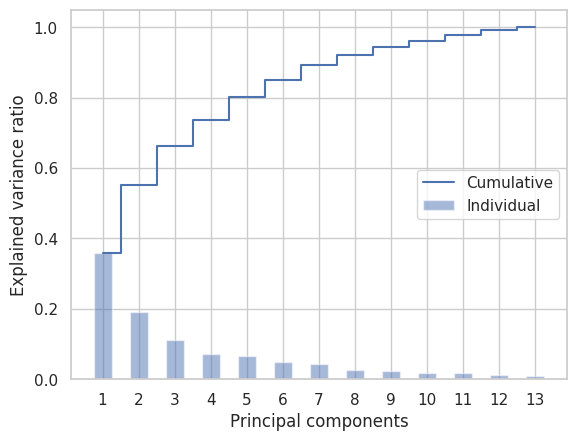

In [8]:
# variance explained ratio
total = sum(np.abs(eigen_vals))
var_exp = [eigen_val / total for eigen_val in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

x_range = range(1, eigen_vals.shape[0] + 1)
plt.bar(x_range, var_exp, align="center", alpha=0.5, width=0.5, label="Individual", tick_label=x_range)
plt.step(x_range, cum_var_exp, where="mid", label="Cumulative")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="center right")

plt.show()

### PCA Projection

We sort eigenvalue–eigenvector pairs by importance and select the top 5 principal components.  
These are stacked to form the projection matrix `w`.

Then, we project the standardized data `z` onto this new subspace to get the PCA-transformed data `z_pca`.


In [9]:
# sort (eigen value, eigen vector) pairs
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(eigen_vals.shape[0])]
eigen_pairs.sort(reverse=True)

In [10]:
w = np.hstack(
    (
        eigen_pairs[0][1][:, np.newaxis],
        eigen_pairs[1][1][:, np.newaxis],
        eigen_pairs[2][1][:, np.newaxis],
        eigen_pairs[3][1][:, np.newaxis],
        eigen_pairs[4][1][:, np.newaxis],
    )
)
print("Projection matrix w:\n", w)

Projection matrix w:
 [[-0.13788809 -0.48583464 -0.20877489  0.0011407  -0.26989127]
 [ 0.24638109 -0.22157478  0.09019328 -0.53313643  0.06287575]
 [ 0.0043183  -0.31528188  0.62374304  0.20534831 -0.16036596]
 [ 0.23737955  0.01214349  0.61379873 -0.0572236   0.06481078]
 [-0.1350017  -0.30028828  0.13573164  0.39169387  0.7063438 ]
 [-0.39586939 -0.07054905  0.14462048 -0.20259928 -0.13330889]
 [-0.42439422 -0.00173207  0.14931754 -0.15557524 -0.09817784]
 [ 0.29913568 -0.02466918  0.16913634  0.17533015 -0.51010843]
 [-0.31280321 -0.04144561  0.15060183 -0.39174378  0.16205372]
 [ 0.09328558 -0.52801878 -0.13608317 -0.07237106 -0.06850459]
 [-0.29956536  0.27405069  0.08255118  0.41943139 -0.19528174]
 [-0.37720252  0.16544914  0.16681112 -0.1904646  -0.09854303]
 [-0.28428101 -0.3695384  -0.12803431  0.22362175 -0.16716868]]


In [11]:
# PCA transformation
z_pca = z.dot(w)
print(f"Before PCA: {z.shape}\nAfter PCA: {z_pca.shape}")

Before PCA: (177, 13)
After PCA: (177, 5)


### Visualization

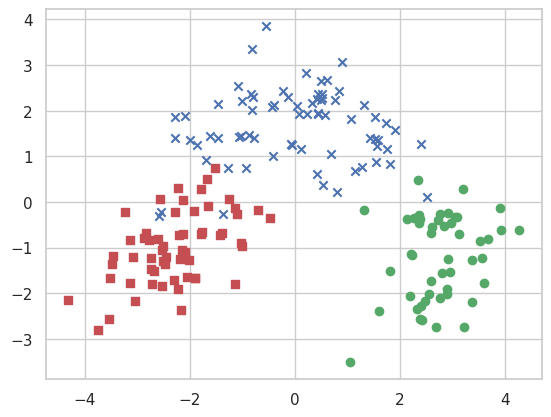

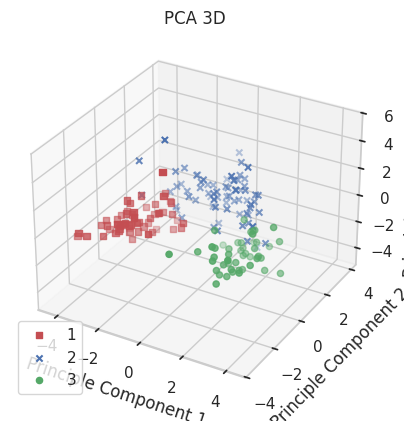

In [12]:
# visualization after PCA
colors = ["r", "b", "g"]
markers = ["s", "x", "o"]
for l, c, m in zip(np.unique(y_wine.values), colors, markers):
    plt.scatter(z_pca[y_wine.values == l, 0], z_pca[y_wine.values == l, 1], color=c, label=l, marker=m)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for l, c, m in zip(np.unique(y_wine.values), colors, markers):
    ax.scatter(
        z_pca[y_wine.values == l, 0],
        z_pca[y_wine.values == l, 1],
        z_pca[y_wine.values == l, 2],
        color=c,
        label=l,
        marker=m,
    )

ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")
ax.set_zlabel("Principle Component 3")
ax.set_title("PCA 3D")

plt.title("PCA 3D")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.legend(loc="lower left")
plt.show()